# Strategy Learner getting data online


Kairoart 2018
"""


## Overview

In this project we will design a learning trading agent. Your choices are:

1. Regression or classification-based learner: Create a strategy using your Random Forest learner. Suggestions if you follow this approach: Classification_Trader_Hints. Important note, if you choose this method, you must set the leaf_size for your learner to 5 or greater. This is to avoid degenerate overfitting in-sample.
2. Reinforcement Learner-based approach: Create a Q-learning-based strategy using your Q-Learner. Read the Classification_Trader_Hints first, because many of the ideas there are relevant for the Q trader, then see Q_Trader_Hints
3. Optimization-based learner: Create a scan-based strategy using an optimizer. Read the Classification_Trader_Hints first, because many of the ideas there are relevant for the Opto trader, then see Opto_Trader_Hints

Regardless of your choice above, your learner should work in the following way:

* In the training phase (e.g., addEvidence()) your learner will be provided with a stock symbol and a time period. It should use this data to learn a strategy. For instance, for a regression-based learner it will use this data to make predictions about future price changes.
* In the testing phase (e.g., testPolicy()) your learner will be provided a symbol and a date range. All learning should be turned OFF during this phase.


If the date range is the same as used for the training, it is an in-sample test. Otherwise it is an out-of-sample test. Your learner should return a trades dataframe like it did in the last project. Here are some important requirements: Your testPolicy() method should be much faster than your addEvidence() method. The timeout requirements (see rubric) will be set accordingly. Multiple calls to your testPolicy() method should return exactly the same result. 

## Tasks

* Devise numerical/technical indicators to evaluate the state of a stock on each day.
* Build a strategy learner based on one of the learners described above that uses the indicators.
* Test/debug the strategy learner on specific symbol/time period problems.
* Write a report describing your learning strategy.

## Data Details, Dates and Rules

* For your report, trade only the symbol JPM. This will enable us to more easily compare results. We will test your learner with other symbols as well.
* You may use data from other symbols (such as SPY) to inform your strategy.
* The in sample/development period is January 1, 2008 to December 31 2009.
* The out of sample/testing period is January 1, 2010 to December 31 2011.
* Starting cash is 100,000.
* Allowable positions are: 1000 shares long, 1000 shares short, 0 shares.
* Benchmark: The performance of a portfolio starting with 100,000 cash, investing in 1000 shares of the symbol in use and holding that position. Include transaction costs.
* There is no limit on leverage.
* Transaction costs: Commission will always be 0.00, Impact may vary, and will be passed in as a parameter to the learner.
* Minimize use of herrings.

## Implement Strategy Learner

For this part of the project you should develop a learner that can learn a trading policy using your learner. You should be able to use your Q-Learner or RTLearner from the earlier project directly, with no changes. If you want to use the optimization approach, you will need to create new code or that. You will need to write code in StrategyLearner.py to "wrap" your learner appropriately to frame the trading problem for it.

### StrategyLearner API

import StrategyLearner as sl
learner = sl.StrategyLearner(verbose = False, impact = 0.000) # constructor
learner.addEvidence(symbol = "AAPL", sd=dt.datetime(2008,1,1), ed=dt.datetime(2009,12,31), sv = 100000) # training phase
df_trades = learner.testPolicy(symbol = "AAPL", sd=dt.datetime(2010,1,1), ed=dt.datetime(2011,12,31), sv = 100000) # testing phase

The input parameters are:

* verbose: if False do not generate any output
* impact: The market impact of each transaction.
* symbol: the stock symbol to train on
* sd: A datetime object that represents the start date
* ed: A datetime object that represents the end date
* sv: Start value of the portfolio

The output result is:

* df_trades: A data frame whose values represent trades for each day. Legal values are +1000.0 indicating a BUY of 1000 shares, -1000.0 indicating a SELL of 1000 shares, and 0.0 indicating NOTHING. Values of +2000 and -2000 for trades are also legal when switching from long to short or short to long so long as net holdings are constrained to -1000, 0, and 1000.

## Goal

Implement a StrategyLearner that trains a QLearner for trading a symbol.

## Import libraries

In [1]:
import pandas as pd
import numpy as np  
import datetime as dt

# To fetch data
from pandas_datareader import data as pdr   
import fix_yahoo_finance as yf  
yf.pdr_override()   

from util import create_df_benchmark, get_data, fetchOnlineData, get_data_av, normalize_data, scaling_data, equity_curve
from strategyLearner import strategyLearner
from marketsim import compute_portvals_single_symbol, market_simulator
from indicators import get_momentum, get_sma, get_sma_indicator, get_rolling_mean, get_rolling_std, get_bollinger_bands, get_RSI
from indicators import plot_bollinger, plot_cum_return,  plot_momentum, plot_sma_indicator, plot_rsi_indicator, plot_momentum_sma_indicator, plot_stock_prices, plot_norm_data_vertical_lines

# TA Library (https://github.com/bukosabino/ta)
from ta import *

# Add plotly for interactive charts
import plotly
from plotly.offline import iplot
import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools

# Jupyter Notebooks
import ipywidgets as widgets
from ipywidgets import interact, interact_manual, interactive, FloatSlider, IntSlider
from IPython.display import display


## Initial Variables

In [2]:
# Start value
def Cash(Cash):
    return Cash 

# Commission function
def commission(Commission):
    return Commission 

# Impact function
def impact(Impact):
    return Impact 

# Datepicker widget funcion
def dates(start_date, end_date):
    start_date = pd.Timestamp(start_date)
    end_date = pd.Timestamp(end_date)
    return start_date, end_date

# Shares
def Shares(Shares):
    return Shares 

# Tickets
df = pd.read_csv('./data/nasdaq_tickers_name.csv', index_col=False, header=0);
tickets = pd.Series(df['Symbol'])
tickets_array = np.array(tickets)

### Widgets

In [3]:
# Star Value widget
cash = interactive(Cash,Cash=IntSlider(min=100000, max=1000000, step=10000));

# Commission widget
com= interactive(commission,Commission=FloatSlider(min=0, max=10, step=0.5));

# Impact widget
impact = interactive(impact,Impact=FloatSlider(min=0, max=5, step=0.01));

# Dates
dates = interactive(dates,
             start_date=widgets.DatePicker(value=pd.to_datetime('2018-01-01')),
             end_date=widgets.DatePicker(value=pd.to_datetime('2019-01-01')))

# Shares
shares = interactive(Shares,Shares=IntSlider(min=1000, max=10000, step=1000));

# Tickets Dropdown
symbol = widgets.Dropdown(
    options=tickets_array,
    value='AMZN',
    description='Ticket:',
    disabled=False,
)



In [4]:
display(symbol)
display(dates)
display(cash)
display(shares)
display(com)
display(impact)


Dropdown(description='Ticket:', index=184, options=('AABA', 'AAL', 'AAME', 'AAOI', 'AAON', 'AAPL', 'AAWW', 'AA…

interactive(children=(DatePicker(value=Timestamp('2018-01-01 00:00:00'), description='start_date'), DatePicker…

interactive(children=(IntSlider(value=100000, description='Cash', max=1000000, min=100000, step=10000), Output…

interactive(children=(IntSlider(value=1000, description='Shares', max=10000, min=1000, step=1000), Output()), …

interactive(children=(FloatSlider(value=0.0, description='Commission', max=10.0, step=0.5), Output()), _dom_cl…

interactive(children=(FloatSlider(value=0.0, description='Impact', max=5.0, step=0.01), Output()), _dom_classe…

### Get portfolio data from Yahoo

In [ ]:
#portf_value = fetchOnlineData(start_d, end_d, symbol)
#portf_value = fetchOnlineData(start_d, symbol, dt.date.today())

## Get Alpha Vantage data

In [5]:
# Import data from Alpha Vantage
symbol = symbol.value
start_d = dates.result[0]
dates = pd.date_range(start_d, dates.result[1])
portf_value = get_data_av(symbol, dates, del_cols=True)

In [ ]:
portf_value.info()

# Calculate indicators values

In [6]:
# Rename 'Adj Close' to symbol
portf_value.rename(columns={'Adj Close': symbol}, inplace=True)
stl = strategyLearner()
df_norm = stl.get_features1(portf_value, symbol, print=True)


In [ ]:
df_norm

# Plot indicators

You must intall jupyterlab/plotly-extension to show charts.

In [ ]:
# Prices

plot_prices = plot_stock_prices(portf_value[symbol], symbol, output_type='nb')
iplot(plot_prices)

In [ ]:
# Momentym
plot_mom = plot_momentum(df_norm, symbol, output_type='nb')
iplot(plot_mom)

## Bollinger Bands

In [ ]:
# Bollinger Bands
plot_boll = plot_bollinger(df_norm, symbol, output_type='nb')
iplot(plot_boll)

In [ ]:
# Adj. Close/SMA
plot_sma = plot_sma_indicator(df_norm, symbol, output_type='nb')
iplot(plot_sma)

In [ ]:
# Momentum/SMA indicator
sma = df_norm['SMA']
mom = df_norm['Momentum']
plot_mom_sma = plot_momentum_sma_indicator(df_norm, symbol, sma, mom, output_type='nb')
iplot(plot_mom_sma)

In [ ]:
# RSI
plot_rsi = plot_rsi_indicator(df_norm, symbol, output_type='nb')
iplot(plot_rsi)

# Trading Agent

In-sample performance

Show the performances of portfolio and benchmark in the in-sample period.

## Splitting data

In [7]:
df = portf_value.copy()
# Rename column Adj Close
df.rename(columns={'Adj Close': symbol}, inplace=True)

# We'll get 70% data to train
split_percentage = 0.7
split = int(split_percentage * len(df))

# Train data set
df_training = df[:split]

# Test data set
df_testing = df[split:]

# Training dates
start_date_training = df_training.index[0]
end_date_training = df_training.index[-1]

# Testing dates
start_date_testing = df_testing.index[0]
end_date_testing = df_testing.index[-1]

In [8]:
df.info()
df_training.info()
df_testing.info()

<class 'pandas.core.frame.DataFrame'>
Index: 303 entries, 2018-03-13 to 2019-05-24
Data columns (total 1 columns):
AABA    303 non-null float64
dtypes: float64(1)
memory usage: 4.7+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 212 entries, 2018-03-13 to 2019-01-14
Data columns (total 1 columns):
AABA    212 non-null float64
dtypes: float64(1)
memory usage: 3.3+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 91 entries, 2019-01-15 to 2019-05-24
Data columns (total 1 columns):
AABA    91 non-null float64
dtypes: float64(1)
memory usage: 1.4+ KB


## Benchmark data

In [9]:
# Get a dataframe of benchmark data. Benchmark is a portfolio starting with
# $100,000, investing in 1000 shares of symbol and holding that position
df_benchmark_trades = create_df_benchmark(df_training, shares.result)

## Training

In [10]:
# Train a StrategyLearner
stl = strategyLearner(num_shares=shares.result, impact=impact.result,
                      commission=com.result, verbose=True,
                      num_states=3000, num_actions=3, dyna=200)

epochs, cum_returns, trades, portvals, df_features, thresholds = stl.add_evidence(df_training, symbol, start_val=cash.result, start_date=start_date_training,
                                       end_date=end_date_training)
df_trades = stl.test_policy(df_training, symbol, start_date=start_date_training,
                            end_date=end_date_training)

/home/emi/PycharmProjects/factors/lib/python3.7/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/emi/PycharmProjects/factors/lib/python3.7/site-packages/pandas/core/frame.py:3790: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/emi/PycharmProjects/factors/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/emi/PycharmProjects/

1 0.03929999999999989
2 0.07719999999999994
3 0.25059999999999993
4 0.21300000000000008
5 0.2821
6 0.20019999999999993
7 0.3002
8 0.30410000000000004
9 0.3071999999999999
10 0.3052999999999999
11 0.3064
12 0.2603
13 0.26370000000000005
14 0.2931999999999999


In [ ]:
df_features.plot()

In [ ]:
trades.plot()

In [ ]:
portvals.plot()

## Training market simulator


In [ ]:
# cum_returns = map(lambda cum_returns: cum_returns * 100, cum_returns)
plot_cum = plot_cum_return(epochs, cum_returns, output_type='nb')
iplot(plot_cum)

In [11]:
# Retrieve performance stats via a market simulator
print("Performances during training period for {}".format(symbol))
print("Date Range: {} to {}".format(start_date_training, end_date_training))
orders_count, sharpe_ratio, cum_ret, std_daily_ret, avg_daily_ret, final_value, cum_ret_bm, avg_daily_ret_bm, std_daily_ret_bm, sharpe_ratio_bm, final_value_bm, portvals, portvals_bm, df_orders = \
    market_simulator(df_training, df_trades, df_benchmark_trades, symbol=symbol,
                     start_val=cash.result, commission=com.result, impact=impact.result)

Performances during training period for AABA
Date Range: 2018-03-13 to 2019-01-14
Sharpe Ratio of Portfolio: 2.1881159593187007
Sharpe Ratio of Benchmark : -0.6497126060743275

Cumulative Return of Portfolio: 0.2935000000000001
Cumulative Return of Benchmark : -0.13680000000000003

Standard Deviation of Portfolio: 0.009155635160361242
Standard Deviation of Benchmark : 0.014479203653274472

Average Daily Return of Portfolio: 0.0012619976367585356
Average Daily Return of Benchmark : -0.0005926055294834562

Final Portfolio Value: 129350.0
Final Benchmark Value: 86320.0

Portfolio Orders count: 212


## Plotting market simulator results

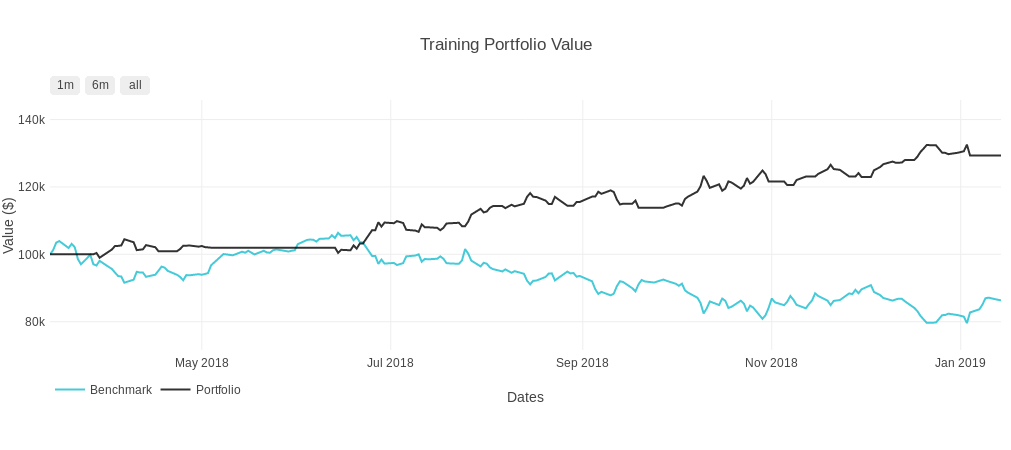

In [12]:
 plot_norm_data = plot_norm_data_vertical_lines(
    df_orders,
    portvals,
    portvals_bm,
    vert_lines=False,
    title="Training Portfolio Value",
    xtitle="Dates",
    ytitle="Value ($)",
    output_type='nb')
iplot(plot_norm_data)    

## Out of sample performance

Show the performances of portfolio and benchmark in the out of sample period. Use the same StrategyLearner trained above and retrieve a trades dataframe via test_policy.

https://www.investopedia.com/articles/trading/10/backtesting-walkforward-important-correlation.asp

In [13]:
# Out-of-sample or testing period: Perform similiar steps as above,
# except that we don't train the data (i.e. run add_evidence again)

df_benchmark_trades = create_df_benchmark(df_testing, shares.result)
df_trades = stl.test_policy(df_testing, symbol, start_date=start_date_testing,
                            end_date=end_date_testing)
    



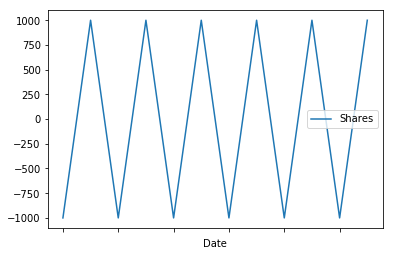

In [14]:
df_trades.plot()

### Test market simulator


In [15]:
# Retrieve performance stats via a market simulator
print("\nPerformances during testing period for {}".format(symbol))
print("Date Range: {} to {}".format(start_date_testing, end_date_testing))

# Retrieve performance stats via a market simulator
test_orders_count, test_sharpe_ratio, test_cum_ret, test_std_daily_ret, test_avg_daily_ret, test_final_value, test_cum_ret_bm, test_avg_daily_ret_bm, test_std_daily_ret_bm, test_sharpe_ratio_bm, test_final_value_bm, test_portvals, test_portvals_bm, test_df_orders = \
    market_simulator(df_testing, df_trades, df_benchmark_trades, symbol=symbol,
                     start_val=portvals['Portfolio'][-1], commission=com.result, impact=impact.result)


Performances during testing period for AABA
Date Range: 2019-01-15 to 2019-05-24
Sharpe Ratio of Portfolio: 1.3088560117306574
Sharpe Ratio of Benchmark : -0.06560405409826485

Cumulative Return of Portfolio: 0.062234248163896444
Cumulative Return of Benchmark : -0.006725937379203684

Standard Deviation of Portfolio: 0.00857738751090823
Standard Deviation of Benchmark : 0.008815359925793654

Average Daily Return of Portfolio: 0.0007072071337950995
Average Daily Return of Benchmark : -3.6430946668398865e-05

Final Portfolio Value: 137400.0
Final Benchmark Value: 128480.0

Portfolio Orders count: 91


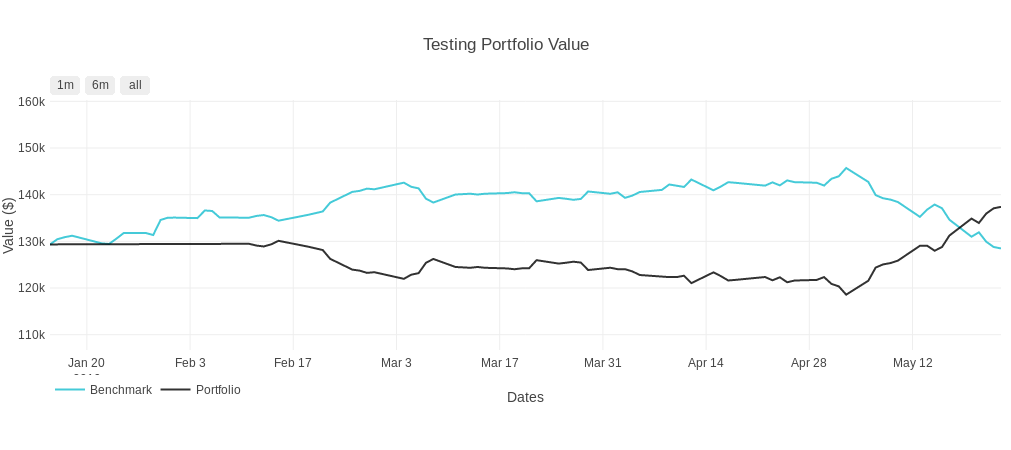

In [16]:
plot_norm_data_test = plot_norm_data_vertical_lines(
    test_df_orders,
    test_portvals,
    test_portvals_bm,
    vert_lines=False,
    title="Testing Portfolio Value",
    xtitle="Dates",
    ytitle="Value ($)",
    output_type='nb')
iplot(plot_norm_data_test)

In [17]:

df = portvals.append(test_portvals, ignore_index=False)


In [93]:
limit =df_testing.index[1]

In [27]:
from plotly.graph_objs import *
def equity_curve1(df, limit, title='Equity Curve', output_type='py'):
    """

    :param df: Dataframe with portfolio in-sample and out-sample values
    :param limit: Where the out-sample starts
    :param output_type: Type of output for plotting in python (py) or in notebook (nb)
    :return: Plot an Equity Curve

    """
    trace_in_sample = go.Scatter(
        x=df.index,
        y=df['Portfolio'],
        name="In-sample",
        line=dict(color='#17BECF'),
        opacity=0.8)



    data = [trace_in_sample]
    
    shape = [{'fillcolor': '#d3d3d3',
              'line': {'color': 'rgb(255,191,0)',
                      'width': 2},
             'opacity': 0.2,
             'type': 'rect',
             'x0': limit,
             'x1': limit,
             'xref': 'x',
             'y0': 0,
             'y1': 1,
             'yref': 'paper'}]
    annotation =  [{'x': limit,
                    'y': 0.05,
                    'xref': 'x',
                    'yref': 'paper',
                    'showarrow': False, 
                    'xanchor': 'left',
                    'text': 'Out-sample'
    }]

    
    layout = go.Layout( 
        dict(
        title=title,
        showlegend=True,

        margin=go.layout.Margin(
            l=50,
            r=50,
            b=100,
            t=100,
            pad=4
        ),
        legend=dict(
            orientation="h"),
        xaxis=dict(
            title='Dates',
            rangeselector=dict(
                buttons=list([
                    dict(count=1,
                         label='1m',
                         step='month',
                         stepmode='backward'),
                    dict(count=6,
                         label='6m',
                         step='month',
                         stepmode='backward'),
                    dict(step='all')
                ])
            ),
            range=[df.index[0], df.index[-1]]),

        yaxis=dict(
            title='Price'),
    
        shapes=shape,
        
        annotations=annotation    
    
        )
    )

    fig = dict(data=data, layout=layout)
    if output_type == 'py':
        chart = plot(fig, show_link=False, output_type='div')
        return chart
    else:
        return fig

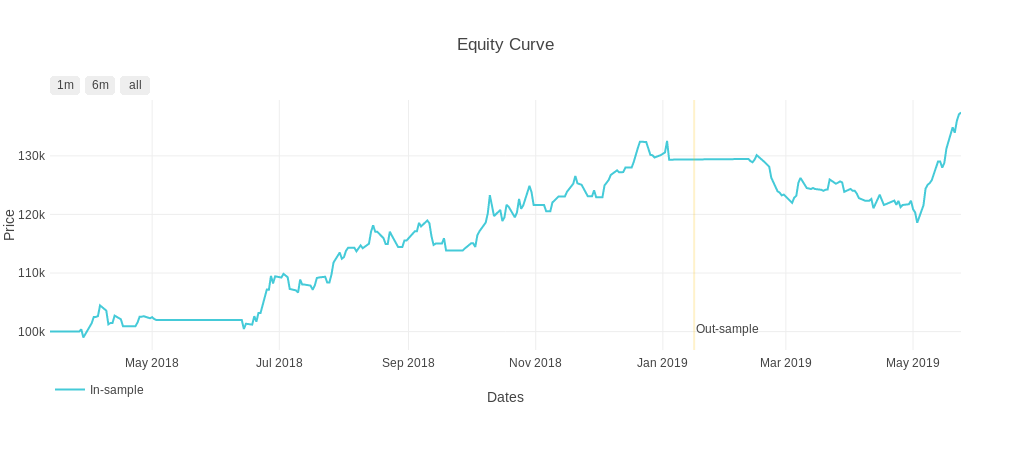

In [28]:
limit =df_testing.index[1]
plot_ec = equity_curve1(df, limit, output_type='nb')
iplot(plot_ec)  

# Report

Describe the steps you took to frame the trading problem as a learning problem for your learner. What are your indicators? Did you adjust the data in any way (dicretization, standardization)? Why or why not?

**Steps:**

1. Get adjusted close prices for symbol.
2. Set the QLearner parameters:
    * num_shares: The number of shares that can be traded in one order
    * epochs: The number of times to train the QLearner
    * num_steps: The number of steps used in getting thresholds for the
    discretization process. It is the number of groups to put data into.
3. Compute technical indicators and use them as features to be fed into a Q-learner.
    * Momentum
    * SMA indicator
    * RSI indicator
4. Get features and thresholds.
5. Define states, actions, and rewards. 
    * States are combinations of our features. 
    * Actions are buy, sell, do nothing. 
    * Rewards:
        Calculate the daily reward as a percentage change in prices: 
        - Position is long: if the price goes up (curr_price > prev_price),
          we get a positive reward; otherwise, we get a negative reward
        - Position is short: if the price goes down, we get a positive reward;
        otherwise, we a negative reward
        - Position is cash: we get no reward
6. Set initial position holding to nothing.
7. Create a series that captures order signals based on actions taken.
8. Iterate over the data by date.
    * Discretize features and return a state. Get a state; add 1 to position so that states >= 0.
    * On the first day, get an action without updating the Q-table.
    * On the last day, close any open positions.
    * Add new_pos to orders.
    * Update current position.
9. Create a trade dataframe.
10. Training: Choose the training period and you iterate over that training period and update your Q-table on each iteration. When you reach the end of that training period you backtest to see how good the model is and you go back and repeat, until the model quits getting better.
Once it's converged you stop, you've got your model.
11. Testing the model: You just backtest it on later data.

    

## Indicator charts

### Momentum chart

In [ ]:
# Specify the start and end dates for this period.
start_d = dt.datetime(2008, 1, 1)
end_d = dt.datetime(2009, 12, 31)

# Set dates
dates = pd.date_range(start_d, end_d)

# Get adjusted close prices for symbol
df = get_data([symbol], dates, addSPY=False)
df = df.dropna()


# Normalize the prices Dataframe
normed = pd.DataFrame()
for column in df:
    normed[column] = df[column].values / df[column].iloc[0];

# 2. Compute momentum
sym_mom = get_momentum(normed[column], window=10)

# 3. Plot raw JPM values and Momentum
plot_momentum(df.index, normed[column], sym_mom, "Momentum Indicator", (12, 8))

### SMA indicator

In [ ]:
# Specify the start and end dates for this period.
start_d = dt.datetime(2008, 1, 1)
end_d = dt.datetime(2009, 12, 31)

# Set dates
dates = pd.date_range(start_d, end_d)

# Get adjusted close prices for symbol
df = get_data([symbol], dates, addSPY=False)
df = df.dropna()

# Normalize the prices Dataframe
normed = pd.DataFrame()
for column in df:
    normed[column] = df[column].values / df[column].iloc[0];

# Compute SMA
sma_JPM, q = get_sma(normed[column], window=10)

# Plot symbol values, SMA and SMA quality
plot_sma_indicator(dates, df.index, normed[column], sma_JPM, q, "Simple Moving Average (SMA)")


### Momentum/SMA cross indicator

In [ ]:
# Specify the start and end dates for this period.
start_d = dt.datetime(2008, 1, 1)
end_d = dt.datetime(2009, 12, 31)

# Set dates
dates = pd.date_range(start_d, end_d)

# Get adjusted close prices for symbol
df = get_data([symbol], dates, addSPY=False)
df = df.dropna()

# Compute momentum
sym_mom = get_momentum(normed[column], window=10)

# Compute SMA
sma_JPM, q = get_sma(normed[column], window=10)

# Plot symbol values, SMA and Momentum
plot_momentum_sma_indicator(dates, df.index, normed[column], sma_JPM, sym_mom, "Momentum/SMA")



### RSI indicator

In [ ]:
# Specify the start and end dates for this period.
start_d = dt.datetime(2008, 1, 1)
end_d = dt.datetime(2009, 12, 31)

# Set dates
dates = pd.date_range(start_d, end_d)

# Get adjusted close prices for symbol
df = get_data([symbol], dates, addSPY=False)
df = df.dropna()

# 1. Compute RSI
rsi_JPM = get_RSI(df[symbol]).values.astype(float)
#print(rsi_JPM.)
# 2. Plot RSI
plot_rsi_indicator(dates, df.index, df[symbol], rsi_JPM, window=14, 
                   title="RSI Indicator", fig_size=(12, 6))


# TODO

Write a PDF report describing your system. The centerpiece of your report should be the description of how you utilized your learner to determine trades